In [1]:
from animalclef.spark import get_spark

spark = get_spark(memory="1g")

25/05/13 04:58:01 WARN Utils: Your hostname, hawksbill-vm resolves to a loopback address: 127.0.1.1; using 192.168.10.12 instead (on interface ens18)
25/05/13 04:58:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/13 04:58:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/13 04:58:02 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
25/05/13 04:58:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
from pathlib import Path
from pyspark.sql import functions as F

root = Path("~/scratch/animalclef").expanduser()

# split 0.6 train, 0.5 val/test, 0.8 known/unknown
df = (
    spark.read.json(
        f"{root}/processed/submissions/*/*/test_best_threshold.json", multiLine=True
    )
    .withColumn("filename", F.input_file_name())
    .withColumn(
        "model", F.udf(lambda p: Path(p).parts[-3], "string")(F.col("filename"))
    )
    .withColumn(
        "epoch", F.udf(lambda p: Path(p).parts[-2], "string")(F.col("filename"))
    )
    .drop("filename")
).where(F.col("model").like("%nonlinear%"))
df.show(n=2, vertical=True)

-RECORD 0------------------------------
 baks            | 0.44243090621791864 
 baus            | 0.8228617995107628  
 crossover_score | 0.6195691067071558  
 mad             | 0.08389073610305786 
 median          | 0.42265942692756653 
 num_neighbors   | 1.0                 
 score           | 0.6033734263701493  
 threshold       | -0.6868686868686869 
 model           | dino-nonlinear-v0   
 epoch           | head_epoch=010      
-RECORD 1------------------------------
 baks            | 0.47585148425894275 
 baus            | 0.7778774038201515  
 crossover_score | 0.6979740804387913  
 mad             | 0.08343243598937988 
 median          | 0.4102182686328888  
 num_neighbors   | 1.0                 
 score           | 0.6084029233816288  
 threshold       | -0.5858585858585859 
 model           | dino-nonlinear-v1   
 epoch           | head_epoch=010      
only showing top 2 rows



In [4]:
df.select("model", "epoch", "score").orderBy(F.desc("score")).show(n=10)
df.select("model", "epoch", "score").orderBy(F.asc("score")).show(n=10)

+-----------------+--------------+------------------+
|            model|         epoch|             score|
+-----------------+--------------+------------------+
|dino-nonlinear-v1|head_epoch=080|0.9638321534732521|
|dino-nonlinear-v1|head_epoch=090|0.9626696014271034|
|dino-nonlinear-v1|          head| 0.954694680509488|
|dino-nonlinear-v1|head_epoch=070| 0.931132072169439|
|dino-nonlinear-v1|head_epoch=060|0.9088662389908567|
|dino-nonlinear-v1|head_epoch=050|0.8813609700200891|
|dino-nonlinear-v0|head_epoch=080|0.8765780052972844|
|dino-nonlinear-v0|          head|0.8754164643870465|
|dino-nonlinear-v0|head_epoch=090|0.8753171582242805|
|dino-nonlinear-v0|head_epoch=070| 0.871497030681678|
+-----------------+--------------+------------------+
only showing top 10 rows

+-----------------+--------------+------------------+
|            model|         epoch|             score|
+-----------------+--------------+------------------+
|dino-nonlinear-v0|head_epoch=010|0.6033734263701493|
|d

Text(0.5, 1.0, 'DINO triplet score over epoch')

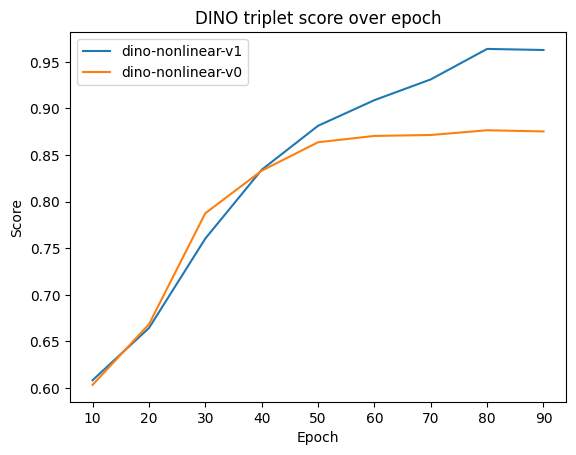

In [5]:
from matplotlib import pyplot as plt

for row in df.select("model").distinct().collect():
    pdf = (
        df.where(f"model = '{row.model}' and epoch like '%=%'")
        .orderBy("epoch")
        .toPandas()
    )

    plt.plot(
        pdf["epoch"].str.split("=", expand=True)[1].astype(int),
        pdf["score"],
        label=row.model,
    )
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("DINO triplet score over epoch")